Bidirectional LSTM RNN Trial 3  :- 

 Processing subject: /content/drive/MyDrive/WithFolderStructure_2796/Subject_47
Processing recipe: /content/drive/MyDrive/WithFolderStructure_2796/Subject_47/S47_Brownie_3DMGX1
Loading Sensor file: /content/drive/MyDrive/WithFolderStructure_2796/Subject_47/S47_Brownie_3DMGX1/2796_11-03_10_54_58-time-synch.txt
Processing recipe: /content/drive/MyDrive/WithFolderStructure_2796/Subject_47/S47_Eggs_3DMGX1
Loading Sensor file: /content/drive/MyDrive/WithFolderStructure_2796/Subject_47/S47_Eggs_3DMGX1/2796_11-03_10_09_24-time-synch.txt
Processing recipe: /content/drive/MyDrive/WithFolderStructure_2796/Subject_47/S47_Pizza_3DMGX1
Loading Sensor file: /content/drive/MyDrive/WithFolderStructure_2796/Subject_47/S47_Pizza_3DMGX1/2796_11-03_09_55_15-time-synch.txt
Processing recipe: /content/drive/MyDrive/WithFolderStructure_2796/Subject_47/S47_Salad_3DMGX1
Loading Sensor file: /content/drive/MyDrive/WithFolderStructure_2796/Subject_47/S47_Salad_3DMGX1/2796_11-

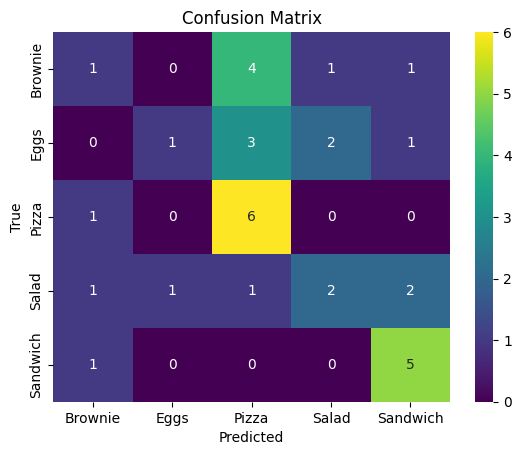


 Accuracy: 0.4411764705882353

 Precision for each class:
[0.25       0.5        0.42857143 0.4        0.55555556]

 Macroaverage Precision: 0.4268253968253969

 Recall for each class:
[0.14285714 0.14285714 0.85714286 0.28571429 0.83333333]

 Macroaverage Recall: 0.4523809523809524

 F1 score for each class:
[0.18181818 0.22222222 0.57142857 0.33333333 0.66666667]

 Macroaverage F1 Score: 0.39509379509379505 



In [1]:
#Bidirectional LSTM RNN Trial 3
print("Bidirectional LSTM RNN Trial 3  :- ")

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Input
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization



# Set the directory path where the dataset is stored
base_path = r"/content/drive/MyDrive/WithFolderStructure_2796"

# Function to load and preprocess data from files
def load_data(base_path):
    #Two empty lists are created
    data = [] #This will store the sensor data for each recipe as a sequence of numeric values sensor readings.
    labels = [] #holds the actual recipe class for each data sample.
    recipes = ["Brownie", "Eggs", "Pizza", "Salad", "Sandwich"] #is a reference list of the recipes , guiding the function on what data to look for.

    # Loop through subjects - To just check the dataset path loaded is right or not like the path exists or not
    if not os.path.exists(base_path):
        print(f"Base path {base_path} does not exist.")
        return data, labels

    #To check for the subjects in the path
    for subject in os.listdir(base_path): #each directory inside base_path corresponds to a different subject in the dataset &returns a list of all the subject folder names.
        subject_path = os.path.join(base_path, subject)#joins base path with subject path
        print(f"\n Processing subject: {subject_path}")

        # Loop for the recipe folders
        for recipe in recipes:
            recipe_path = os.path.join(subject_path, f"S{subject.split('_')[1]}_{recipe}_3DMGX1")#formated string , basically to do like this as -  S01_Brownie_3DMGX1

            # Checking if the recipe folder exists (debugging statement )
            if os.path.exists(recipe_path):
                try:
                    # Print the recipe folder being accessed
                    print(f"Processing recipe: {recipe_path}")

                    # Get the text file for sensor ID 2796
                    sensor_files = [f for f in os.listdir(recipe_path) if f.startswith('2796')]# for each file in the folder, first f represents the each file name
                    if len(sensor_files) == 0:
                        print(f"No sensor file found in {recipe_path}") #Debugging statement
                        continue

                    # Load the file and check its contents
                    file_path = os.path.join(recipe_path, sensor_files[0])
                    print(f"Loading Sensor file: {file_path}")

                    # To seperate values and heaadings
                    df = pd.read_csv(file_path, delimiter='\t', skiprows=2, engine='python') #Python engine for parsing the file to handle any potential formatting issues
                    #read_csv() function is actually used to read files with various delimiters, it’s not limited to comma-separated files (CSV), as delimeter is mentioned \t

                    # Identify numeric columns (ignoring timestamps or non-numeric columns)
                    numeric_columns = df.columns[:-1]  # As last column is non-numeric sys time

                    #  convert all the values in the numeric_columns to numbers or numeric types. If any values can’t be converted text like "abc" they are replaced with NaN.
                    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')#if there are any values that can’t be converted to numbers like text , the coerce put as NaN
                    # 'coerce' means forcing non-numeric data to become something the function can handle
                    df = df.dropna(subset=numeric_columns)  # Drop rows with NaN in numeric columns , example S07 browine file

                    # Append the cleaned numeric data and the recipe label
                    if not df.empty:
                        data.append(df[numeric_columns].values)  # Only numeric data
                        labels.append(recipe)
                    else:
                        print(f"Data from {file_path} is empty after cleaning.")

                except IndexError:
                    print(f"No sensor file found for {subject} - {recipe}")
            else:
                print(f"Recipe folder {recipe_path} not found.")

    return data, labels


# Load data
X, y = load_data(base_path) # X-> sensor data and y-> recipe labels

# Check if any data was loaded
if len(X) == 0:
    print("No data was loaded. Please check your dataset or file paths.")
else:
    print(f"\n Loaded {len(X)} sequences.")

# Filter out empty sequences
X_filtered = [x for x in X if len(x) > 0]# only sequences with actual data are kept and empty are ignored

# Check if any valid sequences remain - for debugging
if len(X_filtered) == 0:
    print("All sequences are empty after filtering. Please check your data preprocessing.")
else:
    print(f"\n Filtered to {len(X_filtered)} non-empty sequences.")

# Ensure all sequences have the same number of features (columns)
#For example, if the first sequence has a shape of (100, 9), this means there are 100 rows and 9 columns (features), so n_features = 9.
if len(X_filtered) > 0:
    n_features = X_filtered[0].shape[1]  # Get number of features from the first sequence
    X_filtered = [x for x in X_filtered if x.shape[1] == n_features]#if it’s not equal to first sequency, that sequence is removed from the list.

    # Filter for the labels to have the same sequence and Avoiding Misalignment
    y_filtered = [y[i] for i in range(len(y)) if len(X[i]) > 0 and X[i].shape[1] == n_features]

    # Check again if we have valid sequences after filtering by features
    if len(X_filtered) == 0:
        print("No sequences remain after filtering by feature size.")
    else:
        print(f"Filtered to {len(X_filtered)} sequences with consistent feature size.")

    # Proceed with padding and scaling if data is available
    if len(X_filtered) > 0:
        # Pad the sequences so that all data have the same length
        X_padded = pad_sequences(X_filtered, padding='post', dtype='float32') #padding zeros at end to maintain same length

        # Preprocess the data - basically normalizing the data to make sure all features have the same scale mean 0, SD -1
        # RNNs that involve gradient-based optimization perform better when the input data is normalized
        scaler = StandardScaler()
        X_scaled = np.array([scaler.fit_transform(x) for x in X_padded]) #both computes the mean and standard deviation of the data

        # Encode the labels - converting labels into a numeric data like "Brownie" → 0, "Pizza" → 1 ...
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y_filtered)

        # Check label distribution before splitting
        unique, counts = np.unique(y_filtered, return_counts=True)
        print("\n Label distribution before splitting:")
        print(dict(zip(unique, counts)))

        # Split into train and test sets (80/20)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
        # stratification is used to ensure that the split between the training and testing sets maintains the equal or same propotion of classes

        # Check label distribution in training and testing sets
        train_unique, train_counts = np.unique(y_train, return_counts=True)
        test_unique, test_counts = np.unique(y_test, return_counts=True)
        print("\n Label distribution in training set:")
        print(dict(zip(train_unique, train_counts)))
        print("\n Label distribution in testing set:")
        print(dict(zip(test_unique, test_counts)))
        print("\n")


        # ------------------- BiLSTM RNN Architecture -------------------
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer to define shape
        #Shape of input data = (batch_size, sequence_length, num_features),used 1 and 2 to select sequence and features

        model.add(Bidirectional(LSTM(10, return_sequences=False)))
        model.add(Dropout(0.5))

        model.add(Dense(60, activation='tanh'))
        model.add(Dense(30, activation='relu'))
        model.add(Dropout(0.5))

        model.add(Dense(60, activation='tanh'))
        model.add(Dense(30, activation='relu'))
        model.add(Dropout(0.5))


        # Output layer
        model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
        #model.add(Dense(5)), activation='softmax'))

        #---------------------------------------------------------------
        # Compile the model
        model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])


        # Train the model
        history = model.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=50,
                            batch_size=64,
                            validation_data=(X_test, tf.keras.utils.to_categorical(y_test))) # Convert labels to one-hot encoding

        """history = model.fit(X_train, y_train, epochs=50,
                            batch_size=90,
                            validation_data=(X_test ,y_test))"""

        # Print the final training accuracy
        train_accuracy = history.history['accuracy'][-1] # -1 is used to access the last value in the list, it will give you the final training accuracy after all epochs have completed.
        print(f'\nTraining accuracy: {train_accuracy}')


        # Evaluate the model
        y_pred = np.argmax(model.predict(X_test), axis=-1)

        '''test_predictions = model.predict(test_image_pixcels)
        test_predictions_classes = np.argmax(test_predictions, axis=1)
        test_true_classes = np.argmax(test_labels, axis=1) '''

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        print("\n Confusion Matrix:")
        print(conf_matrix)

        #plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        #-------------------Evalution Parameters-------------------
        # overall accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print("\n Accuracy:", accuracy)

        # Precession for each class
        precision = precision_score(y_test, y_pred, average=None)
        print("\n Precision for each class:")
        print(precision)

        # Macroaverage precision
        macro_precision = precision_score(y_test, y_pred, average='macro')
        print("\n Macroaverage Precision:", macro_precision)

        # Recall for each class
        recall = recall_score(y_test, y_pred, average=None)
        print("\n Recall for each class:")
        print(recall)

        # Macroaverage recall
        macro_recall = recall_score(y_test, y_pred, average='macro')
        print("\n Macroaverage Recall:", macro_recall)

        # F1 score for each class
        f1 = f1_score(y_test, y_pred, average=None)
        print("\n F1 score for each class:")
        print(f1)

        # Macroaverage F1 score
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        print("\n Macroaverage F1 Score:", macro_f1,"\n")
